In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [2]:
# load png images
img_list = sorted(glob.glob('rois_size20-new/*.jpg'))
mask_list = sorted(glob.glob('rois_mask_size20-new/*.png'))

print(len(img_list), len(mask_list))

244 244


In [3]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ 1st arg: (# of numpy set(x_data, y_data), length of numpy set, height, width, color channel)

In [4]:
# convert images to numpy arrays
for i, img_path in enumerate(img_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    x_data[i] = img

# convert mask images to numpy arrays
for i, img_path in enumerate(mask_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    y_data[i] = img

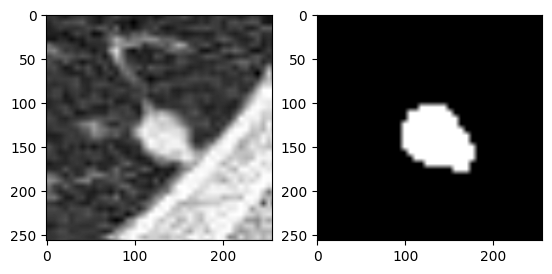

In [5]:
# scale image arrays
# scaling benefits learning process 
x_data /= 255
y_data /= 255

# display samples of image and mask in gray scale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[0].squeeze(), cmap='gray')
ax[1].imshow(y_data[0].squeeze(), cmap='gray')
# ^ since imshow takes 2d array, 3d array is squeezed down to 2d by removing single dimensional entry

In [6]:
# split dataset into train and validation datasets with 20% test portion
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(195, 256, 256, 1)
(49, 256, 256, 1)


In [10]:
inputs = Input(shape=(256, 256, 1))

# encoding
net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

# decoding
net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)

# output with 1 channel for gray scale segmenation
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

# use binary cross entropy with sigmoid function 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       7385

In [11]:
from keras.utils import plot_model

# Visualize the model and save to a file
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
# reduce learning rate when not improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)

# train model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32, callbacks=[reduce_lr])

Epoch 1/50
7/7 [==============================] - 26s 3s/step - loss: 0.2760 - acc: 0.9418 - mse: 0.0676 - val_loss: 0.2150 - val_acc: 0.9477 - val_mse: 0.0368 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - 18s 3s/step - loss: 0.2427 - acc: 0.9418 - mse: 0.0415 - val_loss: 0.1999 - val_acc: 0.9477 - val_mse: 0.0365 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - 17s 2s/step - loss: 0.1925 - acc: 0.9418 - mse: 0.0402 - val_loss: 0.1869 - val_acc: 0.9477 - val_mse: 0.0401 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - 18s 3s/step - loss: 0.1810 - acc: 0.9418 - mse: 0.0406 - val_loss: 0.1658 - val_acc: 0.9477 - val_mse: 0.0354 - lr: 0.0010
Epoch 5/50
7/7 [==============================] - 19s 3s/step - loss: 0.1820 - acc: 0.9418 - mse: 0.0398 - val_loss: 0.1590 - val_acc: 0.9477 - val_mse: 0.0349 - lr: 0.0010
Epoch 6/50
7/7 [==============================] - 17s 3s/step - loss: 0.1724 - acc: 0.9418 - mse: 0.0391 - val_loss: 0.1611 - val_acc: 

In [21]:
# save model
model.save('image_segmentation.model')

INFO:tensorflow:Assets written to: image_segmentation.model\assets


INFO:tensorflow:Assets written to: image_segmentation.model\assets


In [22]:
# Evaluate the model on the validation data
loss_and_metrics = model.evaluate(x_val, y_val)

print("Validation Loss:", loss_and_metrics[0])
print("Validation Accuracy:", loss_and_metrics[1])  # Or appropriate index for accuracy


2/2 [==============================] - 1s 339ms/step - loss: 0.1182 - acc: 0.9477 - mse: 0.0293
Validation Loss: 0.11819639801979065
Validation Accuracy: 0.9476866722106934


Text(0.5, 0, 'epoch')

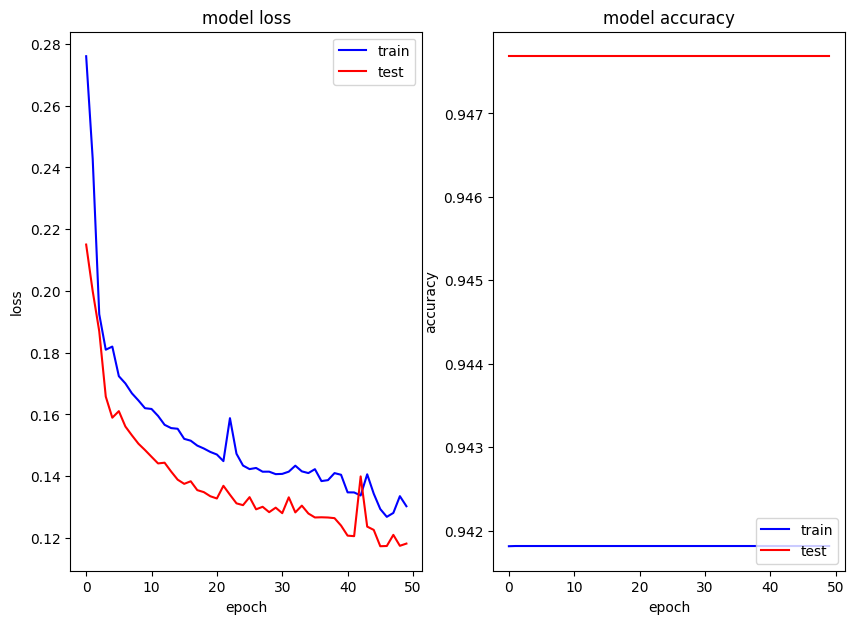

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history.history['loss'], 'b')
ax[0].plot(history.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history.history['acc'], 'b')
ax[1].plot(history.history['val_acc'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

2/2 [==============================] - 1s 364ms/step


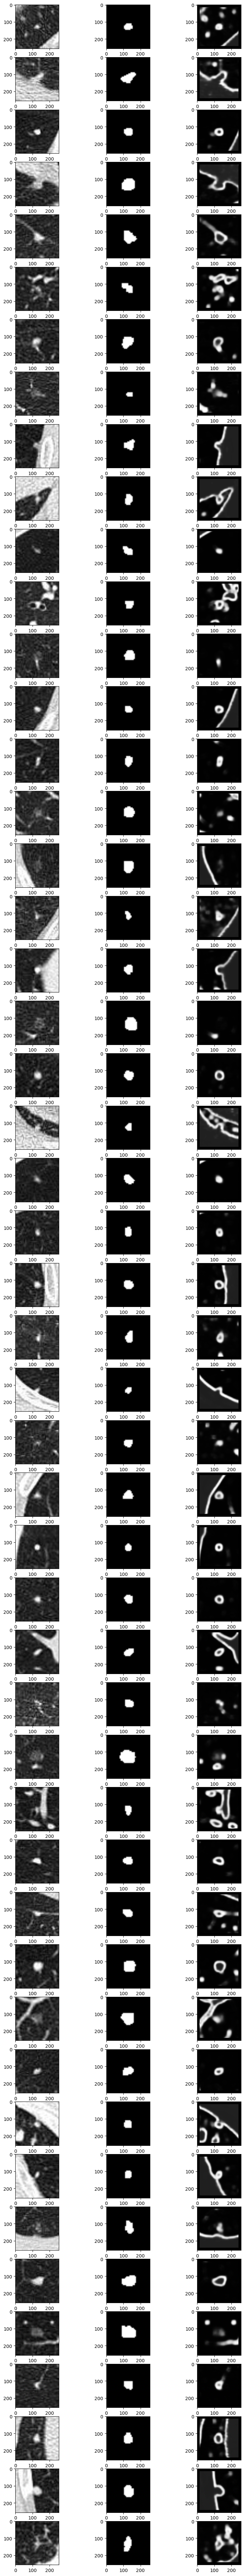

In [24]:
# predict segmentation
preds = model.predict(x_val)

# show results
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))
for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')